<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Project: HeadHunter Job Openings Analysis
   

In [108]:
import pandas as pd
import plotly.express as px
import psycopg2
import requests
import settings
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

from bs4 import BeautifulSoup
from collections import Counter

In [109]:
# The database connection settings are stored in the file settings.py. 
# This file has been excluded from commits via an entry in .gitignore.

In [110]:
connection = psycopg2.connect(
    dbname=settings.DBNAME,
    user=settings.USER,
    host=settings.HOST,
    password=settings.PASSWORD,
    port=settings.PORT
)

# Unit 3. Preliminary data analysis

1. Write a query to count the number of job openings in the database (job openings are located in the table 'vacancies').

In [111]:
query_3_1 = f'''
    SELECT COUNT(*)
    FROM public.vacancies
'''

In [112]:
df = pd.read_sql_query(query_3_1, connection)
display('Number of job openings:')
df

'Number of job openings:'

,count
0,49197


2. Write a query to count the number of employers (table 'employers').

In [113]:
query_3_2 = f'''
    SELECT COUNT(*)
    FROM public.employers
'''

In [114]:
df = pd.read_sql_query(query_3_2, connection)
display('Number of employers:')
df

'Number of employers:'

,count
0,23501


3. Write a query to count the number of areas (table 'area').

In [115]:
query_3_3 = f'''
    SELECT COUNT(*)
    FROM public.areas
'''

In [116]:
df = pd.read_sql_query(query_3_3, connection)
display('Number of areas:')
df

'Number of areas:'

,count
0,1362


4. Write a query to count the number of industries in the database (table 'industries').

In [117]:
query_3_4 = f'''
    SELECT COUNT(*)
    FROM public.industries
'''

In [118]:
df = pd.read_sql_query(query_3_4, connection)
display('Number of industries:')
df

'Number of industries:'

,count
0,294


***

## Results of preliminary data analysis
* The number of job openings is around the double number of employers which results on average in around two job openings per employer.
* The number of areas is very high and should cover a broad geography. This could be a topic for more detailed analysis.
* The number of industries is also very high which should cover the job market to a large extent.

# Unit 4. Detalied job openings analisys

1. Write a query to calculate the number of job openings (column 'cnt') in each area (column 'area').
Order by the number of job openings descending.

In [119]:
query_4_1 = f'''
    SELECT 
        a.name AS area, 
        COUNT(*) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.areas AS a ON v.area_id = a.id
    GROUP BY
        a.id
    ORDER BY
        cnt DESC
'''

In [120]:
df = pd.read_sql_query(query_4_1, connection)
display('Number of job openings per area:')
df

'Number of job openings per area:'

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Кизляр,1
765,Джизак,1
766,Эртиль,1
767,Арсеньев,1


1a. Present the number of job openings per area on a diagram.

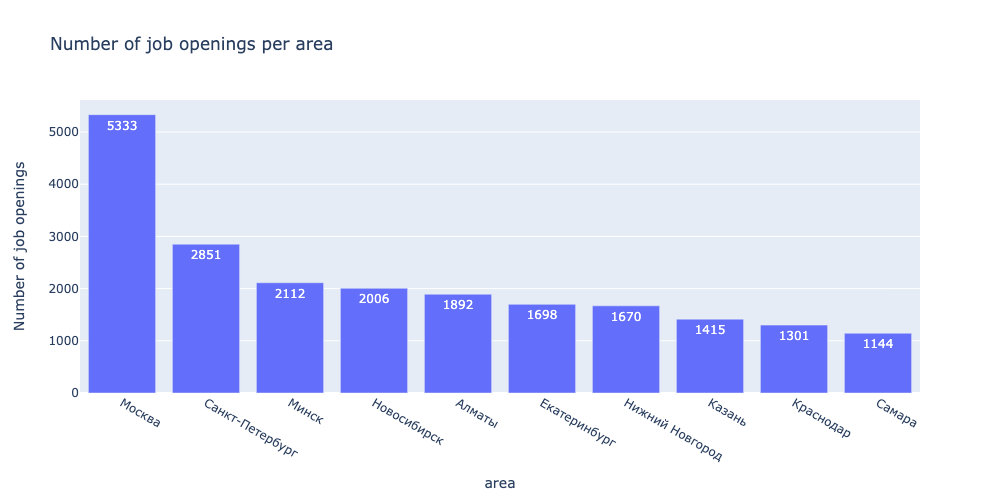

In [121]:
fig = px.bar(
    data_frame=df.head(10),
    x='area',
    y='cnt',
    width=1000,
    height=500,
    title='Number of job openings per area',
    text_auto=True
).update_layout(
    yaxis_title='Number of job openings'
)
fig.show('png')

2. Write a query to determine the number of job openings having a value in at least one of the two salary fields.

In [122]:
query_4_2 = f'''
    SELECT 
        COUNT(*) AS cnt
    FROM
        public.vacancies
    WHERE
        salary_from IS NOT NULL
        OR salary_to IS NOT NULL
'''

In [123]:
df = pd.read_sql_query(query_4_2, connection)
display('Number of job openings which have salary information:')
df

'Number of job openings which have salary information:'

,cnt
0,24073


3. Find the mean values for the lower and upper salary boundaries. Round the values to a whole number.

In [124]:
query_4_3 = f'''
    SELECT
        ROUND(AVG(salary_from)) AS avg_salary_from,
        ROUND(AVG(salary_to)) AS avg_salary_to
    FROM
        public.vacancies
'''

In [125]:
df = pd.read_sql_query(query_4_3, connection)
display('Mean values of salary boundaries:')
display(df)
avg_salary_from = df.loc[0, 'avg_salary_from']
avg_salary_to = df.loc[0, 'avg_salary_to']


'Mean values of salary boundaries:'

,avg_salary_from,avg_salary_to
0,71065.0,110537.0


3a. Present the salary information on a diagram.

In [126]:
query_4_3a = f'''
    SELECT 
        salary_from,
        salary_to
    FROM
        public.vacancies
    WHERE
        salary_from IS NOT NULL
        OR salary_to IS NOT NULL
'''

In [127]:
df = pd.read_sql_query(query_4_3a, connection)
df

,salary_from,salary_to
0,64000.0,NaN
1,15000.0,NaN
2,40000.0,60000.0
3,50000.0,NaN
4,150000.0,NaN
...,...,...
24068,50000.0,NaN
24069,102500.0,NaN
24070,40000.0,78000.0
24071,60000.0,NaN


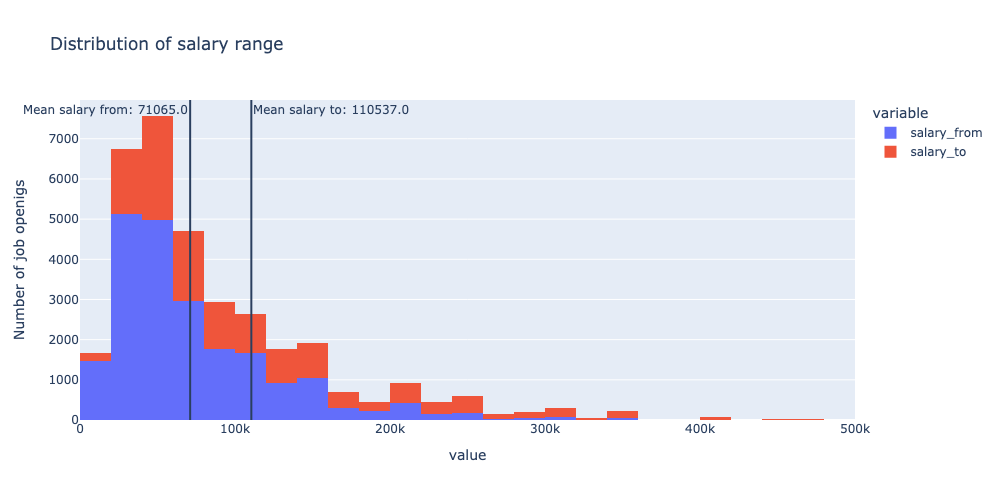

In [128]:
fig = px.histogram(
    data_frame=df,
    width=1000,
    height=500,
    nbins=50,
    title='Distribution of salary range'
).update_layout(
    yaxis_title='Number of job openigs',
    xaxis_range=[0, 500000]
)
fig.add_vline(
    x=avg_salary_from,
    annotation_text=f'Mean salary from: {avg_salary_from}',
    annotation_position='top left'
)
fig.add_vline(
    x=avg_salary_to,
    annotation_text=f'Mean salary to: {avg_salary_to}',
    annotation_position='top right'
)
fig.show('png')

4. Write a query to count the number of job openings (column 'cnt') for each combination of work schedule (column 'schedule') and employment type (column 'employment'). Order the results by the number of job openings descending.


In [129]:
query_4_4 = f'''
    SELECT
        schedule,
        employment,
        COUNT(*) AS cnt
    FROM
        public.vacancies
    GROUP BY
        schedule,
        employment
    ORDER BY
        cnt DESC
'''

In [130]:
df = pd.read_sql_query(query_4_4, connection)
display('Number of job openings by work schedule and employment type:')
df

'Number of job openings by work schedule and employment type:'

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


4a. Present the work schedule and employment type information on a diagram.

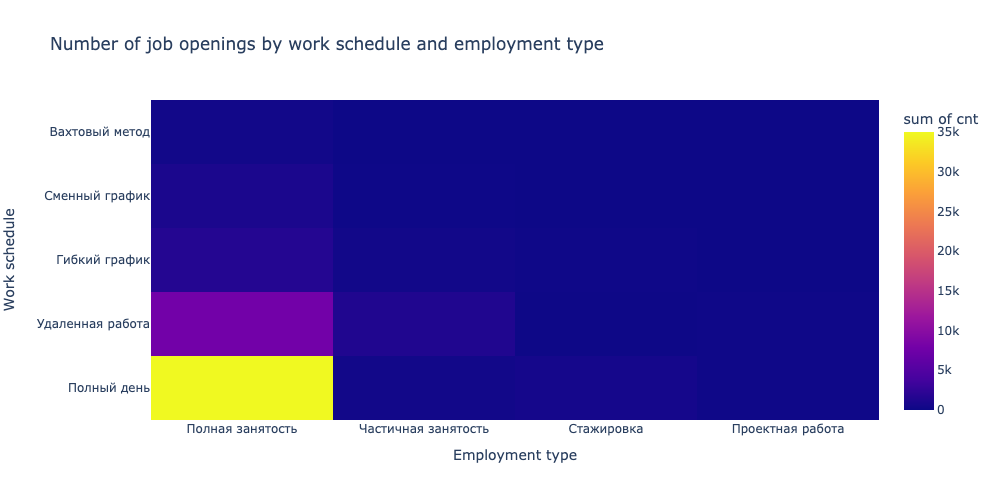

In [149]:
fig = px.density_heatmap(
    df,
    x='employment',
    y='schedule',
    z='cnt',
    range_color=[0, 35000],
    width=1000,
    height=500,
    title='Number of job openings by work schedule and employment type'
).update_layout(
    yaxis_title='Work schedule',
    xaxis_title='Employment type'
)
fig.show('png')

5. Write a query to get the number of job openings (column 'cnt') having a specific required experience (column 'experience'). Order by number of job openings.

In [151]:
query_4_5 = f'''
    SELECT
        experience,
        COUNT(*) AS cnt
    FROM
        public.vacancies
    GROUP BY
        experience
    ORDER BY
        cnt
'''

In [152]:
df = pd.read_sql_query(query_4_5, connection)
display('Number of job openings by work experience:')
df

'Number of job openings by work experience:'

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


5a. Present the work experience information on a diagram.

***

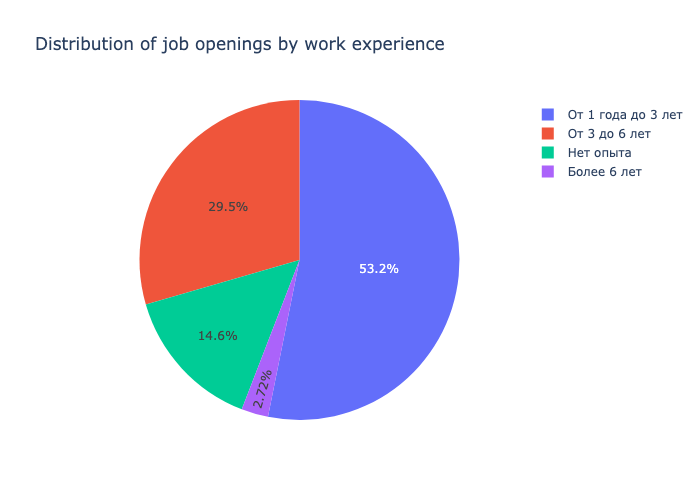

In [155]:
fig = px.pie(
    data_frame=df,
    values='cnt',
    names='experience',
    width=700,
    height=500,
    title='Distribution of job openings by work experience'
)
fig.show('png')

## Results of detalied job openings analisys
* Top 5 areas of job openings total to around 30 % of all job openings.
* Job openings are not only from Russia, but at least such countries as Belarus and Kazakhstan are represented.
* Salary information is available for around 50 % of the job openings. Based on the theory which we learned about data cleaning, these two columns ('salary_from' and 'salary_to') should be analyzed more precisely and if any of them has more than 30-40 % of empty cells, it should not be considered for the further analysis.
* The mean salary boundaries are 71065 and 110537, which means it is a difference of around 50 %. This seems plausible.
* The work schedule and employment type distribution show that the observed job market is mostly a classical one with full time jobs on-site (around 70 % of all job openings). 15 % of full time home office jobs are probably a consequence of the pandemics.
* Most of the job openings (> 50%) are for candidates with 1-3 years of experience. To me it is a sign of a labor shortage on the job market, the companies are ready to take less experienced candidates.

# Unit 5. Employer analysis

1. Write a query to find out which employers are on rank 1 and 5 by number of job openings.

In [156]:
query_5_1 = f'''
    SELECT
        e.name,
        COUNT(*) AS cnt
    FROM
        public.employers AS e
        JOIN public.vacancies AS v ON e.id = v.employer_id
    GROUP BY
        e.id
    ORDER BY
        cnt DESC
'''

In [157]:
df = pd.read_sql_query(query_5_1, connection)
display('Number of job openings by employer:')
df

'Number of job openings by employer:'

,name,cnt
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331
...,...,...
14901,Евсеев Сергей Владимирович,1
14902,Кадровые технологии,1
14903,ЛОМБАРД 24,1
14904,Авто-Компонент ТД,1


1a. Present the number of job openings by employer on a diagram.

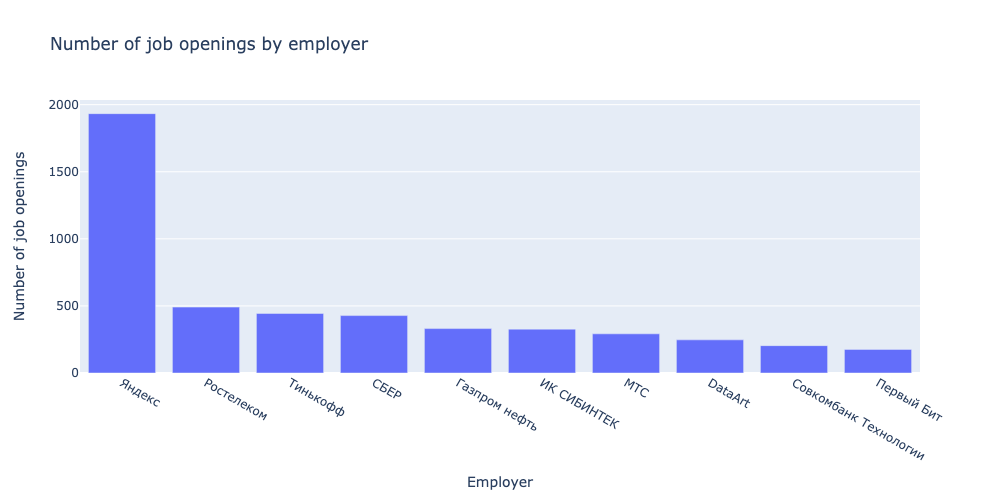

In [160]:
fig = px.bar(
    data_frame=df.head(10),
    x='name',
    y='cnt',
    width=1000,
    height=500,
    title='Number of job openings by employer'
).update_layout(
    xaxis_title='Employer',
    yaxis_title='Number of job openings'
)
fig.show('png')

2. Write a query to determine the number of employers and job openings for each area. From the areas which don't have job openings find the one having the most employers.

In [76]:
query_5_2 = f'''
    SELECT
        a.name,
        COUNT(DISTINCT e.id) AS cnt_employers
    FROM
        areas AS a
        JOIN public.employers AS e ON a.id = e.area
        LEFT JOIN public.vacancies AS v ON a.id = v.area_id
    WHERE
        v.id IS NULL
    GROUP BY
        a.id
    ORDER BY
        cnt_employers DESC
'''

In [77]:
df = pd.read_sql_query(query_5_2, connection)
display('Number of employers in regions which don''t have job openings:')
df

'Number of employers in regions which dont have job openings:'

,name,cnt_employers
0,Россия,410
1,Казахстан,207
2,Московская область,75
3,Краснодарский край,19
4,Беларусь,18
...,...,...
181,Витебская область,1
182,Ивацевичи,1
183,Дубровно,1
184,Буда-Кошелево,1


3. For each employer count the number of areas in which this employer publishes the job openings. Order the results by the number of areas  descending.


In [78]:
query_5_3 = f'''
    SELECT
        e.name,
        COUNT(DISTINCT v.area_id) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.employers AS e ON v.employer_id = e.id
    GROUP BY
        e.id
    ORDER BY
        cnt DESC
'''

In [79]:
df = pd.read_sql_query(query_5_3, connection)
display('Number of areas per employer:')
df

'Number of areas per employer:'

,name,cnt
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


4. Write a query to count the number of employers for which the industry is not specified.

In [80]:
query_5_4 = f'''
    SELECT
        COUNT(*) AS cnt
    FROM
        public.employers AS e
        LEFT JOIN public.employers_industries AS ei ON e.id = ei.employer_id
    WHERE
        ei.industry_id IS NULL
'''

In [81]:
df = pd.read_sql_query(query_5_4, connection)
display('Number of employers without industries:')
df

'Number of employers without industries:'

,cnt
0,8419


5. Write a query to get the employer company name ranked third in the list of the employers which are active in four industries, ordered by name.

In [82]:
query_5_5 = f'''
    SELECT
        e.name
    FROM
        public.employers AS e
        JOIN public.employers_industries AS ei ON e.id = ei.employer_id
    GROUP BY
        e.id
    HAVING
        COUNT(ei.industry_id) = 4
    ORDER BY
        e.name
'''

In [83]:
df = pd.read_sql_query(query_5_5, connection)
display('Employers active in four industries:')
df

'Employers active in four industries:'

,name
0,101 Интернет
1,21vek.by
2,2ГИС
3,2К
4,4 пикселя +
...,...
1133,ЮРИОН
1134,ЮТИП Технологии
1135,ЯКласс
1136,ЯрНео


6. Write a query to determine the number of employers which are active in the software development industry.

In [84]:
query_5_6 = f'''
    SELECT
        COUNT(DISTINCT e.id) AS cnt
    FROM
        public.employers AS e
        JOIN public.employers_industries AS ei ON e.id = ei.employer_id
        JOIN public.industries AS i ON ei.industry_id = i.id
    WHERE
        i.name = 'Разработка программного обеспечения'
'''

In [85]:
df = pd.read_sql_query(query_5_6, connection)
display('Number of employers which are active in software development:')
df

'Number of employers which are active in software development:'

,cnt
0,3553


7. For the company "Yandex" determine the list of million-areas, in which there are job openings of the company. Also get the number of job openings in each of these areas. Add a row with the total number of company's job openings. Order the results by number.

The list of the million-cities can be taken from [here](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

In [86]:
million_areas = []

url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'

response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
for tr in page.find_all('tbody')[1].find_all('tr')[1:]:
    million_areas.append(tr.find('a').text)

million_areas

['Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Нижний Новгород',
 'Красноярск',
 'Челябинск',
 'Самара',
 'Уфа',
 'Ростов-на-Дону',
 'Краснодар',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград']

In [87]:
query_5_7 = f'''
    SELECT
        a.name,
        COUNT(*) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.areas AS a ON v.area_id = a.id
        JOIN public.employers AS e ON v.employer_id = e.id
    WHERE
        e.name = 'Яндекс'
        AND a.name IN ('{'\', \''.join(million_areas)}')
    GROUP BY
        a.id
    UNION
    SELECT
        'Total',
        COUNT(*) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.areas AS a ON v.area_id = a.id
        JOIN public.employers AS e ON v.employer_id = e.id
    WHERE
        e.name = 'Яндекс'
        AND a.name IN ('{'\', \''.join(million_areas)}')
    ORDER BY
        cnt
'''

In [88]:
df = pd.read_sql_query(query_5_7, connection)
display('Yandex job openings in the million-areas:')
df

'Yandex job openings in the million-areas:'

,name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

## Results of employer analysis
* A previous assumption that there are on average 2 job openings per employer turned out to be wrong. Top employer has around two thousand job openings, employers 2 - 5 have over 300 job openings. This means that thousands of employers have just one job opening.
* Further analysis shows that there are areas which don't have any job openings and there are hundreds of registered employers which don't have any job openings.
* Some larger employers have job openings in more than a hunderd areas. They are really profiting from the platforms like HeadHunter, because with a single platform they can target a broad set of areas.
* For around 1/3 of employers the industries are not specified. I would recommend to fill this gap to enhance search over their job openings.
* On the other hand there are over 1000 employers who specify four industries. They would be found in the job searches for those industries, which makes their job campaigns more efficient.
* Around 7% of the employers are active in software development. This confirms that HeadHunter is not a niche platform for the IT industry.
* Yandex as the market leader in terms of the job openings has open positions in all million-areas in Russia. I think this means that Moscow and Saint-Petersburg are not supplying enough talent to Yandex and the company has to expand and seek for the talent country-wide.

# Unit 6. Data science job openings analysis

1. How many job openings are realted to data?

We consider a job opening related to data if its title has the words 'data' or 'данн' (rus: 'data').

In [89]:
query_6_1 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        LOWER(name) LIKE '%data%'
        OR LOWER(name) LIKE '%данн%'
'''

In [90]:
df = pd.read_sql_query(query_6_1, connection)
display('Number of job openings related to data:')
df

'Number of job openings related to data:'

,count
0,1771


2. How many job openings for a junior data scientist are available?

A job opening is a data scientist one if its title contains one of the following phrases:
* 'data scientist'
* 'data science'
* 'исследователь данных' (rus: 'data researcher')
* 'ML' (don't include job openings for HTMML)
* 'machine learning'
* 'машинн%обучен%' (rus: 'machine learning')

Job openings for the junior level are the following ones:
* job title contains the word 'junior' or
* required experience is 'Нет опыта' (rus: 'no experience') or
* type of employment is 'Стажировка' (rus: 'internship')

In [91]:
query_6_2 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            LOWER(name) LIKE '%junior%'
            OR experience = 'Нет опыта'
            OR employment = 'Стажировка'
        )
'''

In [92]:
df = pd.read_sql_query(query_6_2, connection)
display('Number of job openings for a junior data scientist:')
df

'Number of job openings for a junior data scientist:'

,count
0,51


3. How many data scientist job openings are available, which have SQL or postgres as a key skill?

Use the same DS criteria as in the previous task.

In [93]:
query_6_3 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            key_skills LIKE '%SQL%'
            OR key_skills LIKE '%postgres%'
        ) 
'''

In [94]:
df = pd.read_sql_query(query_6_3, connection)
display('Number of data science job openings with key skill SQL or postgres:')
df

'Number of data science job openings with key skill SQL or postgres:'

,count
0,229


4. Check the frequency of Python in the DS skillset required for the employers. For that calculate the number of job openings in which 'Python' is specified as a key skill.

In [95]:
query_6_4 = f'''
    SELECT
        COUNT(*)
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR LOWER(name) LIKE '%ml%' AND LOWER(name) NOT LIKE '%html%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            lower(key_skills) LIKE '%python%'
        ) 
'''

In [96]:
df = pd.read_sql_query(query_6_4, connection)
display('Number of data science job openings with key skill Python:')
df

'Number of data science job openings with key skill Python:'

,count
0,357


5. How many key skills are specified on average for the DS job openings? Round the result to two decimal digits.

In [97]:
query_6_5 = f'''
    SELECT
        ROUND(AVG(CARDINALITY(STRING_TO_ARRAY(key_skills, '\t'))), 2) AS cnt_skills_avg
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )        
'''

In [98]:
df = pd.read_sql_query(query_6_5, connection)
display('Average number of key skills in DS job openings:')
df

'Average number of key skills in DS job openings:'

,cnt_skills_avg
0,6.41


6. Write a query to determine the mean salary for DS job openings for each type of required work experience.

While working on the task consider the following:
1. Only pick the job openings which have a value in at least one of the salary fields ('salary_from' and 'salary_to').
2. If both salary fields have a value, take their average, otherwise take the available field value.
3. Use the function [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull) to take an alternative value in case of NULL values.

Find out on which average salary a DS with 3 to 6 years of experience can count. Round the result to a whole number.

In [99]:
query_6_6 = f'''
    SELECT
        experience,
        ROUND(AVG(CASE
            WhEN salary_from IS NOT NULL AND salary_to IS NOT NULL
                THEN (salary_from + salary_to) / 2
            ELSE COALESCE(salary_from, 0) + COALESCE(salary_to, 0)
        END)) AS salary
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND (
            salary_from IS NOT NULL
            OR salary_to IS NOT NULL
        )
    GROUP BY
        experience
'''

In [100]:
df = pd.read_sql_query(query_6_6, connection)
display('Average salaries for DS job openings per experience level:')
df

'Average salaries for DS job openings per experience level:'

,experience,salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


***

## Results of data science job openings analysis
* Over 3% of all job openings are related to data. Considering that the job openings of all industries are present this is a high number. Also the number of data related job openings is around 50% of the number of job openings in the software development industry. It would be interesting to observe this trend in the future. If the number of data jobs grows faster than the number of software development jobs, it means that the market is turning from algorithmic programming to data models as a means of solving tasks.
* Only 51 job openings are available to junior data scientists. It is 0.1% of all available job openings. This means a very high competition to enter the segment of data science.
* As requested skills SQL and postgres are specified 229 times and Python - 357 times. We can assume that in around 1/3 of job openings a non-relational DB or some other data source is used.
* On average a data science candidate must posess 6.41 skills. As a further analysis it would be interesting to compare this number with other industries and to identify the most frequently requested skills for data scientists.
* The salary distribution of data science candidates based on their experience shows that the junior salary is almost doubling with 1-3 years of experience and its trippling with 3-6 years of experiens. This makes the data science industry very attractive. As further analysis it would be interesting to identify data science salareies for candidates with more than 6 years of experience, however this has to be done on a different dataset.

# Overall project results
## General results
* HeadHunter covers a large geographic area and includes jobs from many industries, which makes it attractive for a large number of employers and job seekers.
* The service has job openings from huge employers like Yandex as well as from very small companies. This proves that the business model of HeadHunter makes it very accessible for all types and sizes of businesses. 
* The fact that only 7% of the employers are involved into software development confirms that HeadHunter is not a purely IT oriented platform.
* With Yandex as the largest client represented in many geographic areas I would recommend HeadHunter to put a special team to handle Yandex to increase the customer satisfaction.
* Data related jobs and data science in particular are a solid part of all job openings base. However not too many positions are available for the beginners. 
## Future analysis which can be made
- Analyze how broad is geography of HeadHunter in terms of countries. A data source for city names and their countries will be required for such analysis. This knowledge can help the company to expand.
- Find the employers which have a higher frequency of provided salary data in their job openings. Using additional data verify if these employers quicker find employees. The outcome can stimulate the other employers to specify the salary data in the job openings.
- It would be interesting to observe the relative number of data science job openings over time and see the trends in this business area.

# Unit 7. Additional data analysis

1. Write a query to identify the most frequently requested skills in the data science job openigs.

In [101]:
query_7_1 = f'''
    SELECT
        STRING_TO_ARRAY(key_skills, '\t') AS skills
    FROM
        public.vacancies
    WHERE
        (
            LOWER(name) LIKE '%data scientist%'
            OR LOWER(name) LIKE '%data science%'
            OR LOWER(name) LIKE '%исследователь данных%'
            OR name LIKE '%ML%' AND name NOT LIKE '%HTML%'
            OR LOWER(name) LIKE '%machine learning%'
            OR LOWER(name) LIKE '%машинн%обучен%%'
        )
        AND key_skills IS NOT NULL
'''

In [102]:
skills = []
df = pd.read_sql_query(query_7_1, connection)
for index, row in df.iterrows():
    # Put all skills of all data science job openings into a single list.
    skills.extend(row["skills"])

# Use a Counter data type to calculate and output the frequency of each skill.
cnt = Counter(skills)
display('Most frequently requested skills in the data science job openings:')
cnt.most_common(10)


'Most frequently requested skills in the data science job openings:'

[('Python', 348),
 ('SQL', 191),
 ('Machine Learning', 114),
 ('Git', 66),
 ('Математическая статистика', 62),
 ('Data Analysis', 54),
 ('Data Science', 52),
 ('Pandas', 52),
 ('ML', 49),
 ('Английский язык', 48)]

2. Write a query to get the number of most frequent industries for the available job openings.

In [103]:
query_7_2 = f'''
    SELECT
        i.name,
        COUNT(*) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.employers AS e ON v.employer_id = e.id
        JOIN public.employers_industries AS ei ON e.id = ei.employer_id
        JOIN public.industries AS i ON ei.industry_id = i.id
    GROUP BY
        i.id
    ORDER BY
        COUNT(*) DESC
'''

In [104]:
df = pd.read_sql_query(query_7_2, connection)
display('Most frequent industries for the job openings:')
df.head(20)

'Most frequent industries for the job openings:'

,name,cnt
0,Разработка программного обеспечения,12499
1,"Системная интеграция, автоматизации технологи...",11034
2,"Интернет-компания (поисковики, платежные систе...",6413
3,Банк,2742
4,Мобильная связь,1585
5,Кадровые агентства,1143
6,Консалтинговые услуги,1137
7,Интернет-провайдер,1095
8,Розничная сеть (продуктовая),1034
9,Фиксированная связь,1028


3. Write a query to find the leading industries for job openings with a possibility to work remotely.

In [105]:
query_7_3 = f'''
    SELECT
        i.name,
        COUNT(*) AS cnt
    FROM
        public.vacancies AS v
        JOIN public.employers AS e ON v.employer_id = e.id
        JOIN public.employers_industries AS ei ON e.id = ei.employer_id
        JOIN public.industries AS i ON ei.industry_id = i.id
    WHERE
        v.schedule = 'Удаленная работа'
    GROUP BY
        i.id, v.schedule
    ORDER BY
        COUNT(*) DESC
'''

In [106]:
df = pd.read_sql_query(query_7_3, connection)
display('Number of job openings for remote work by industry:')
df.head(20)

'Number of job openings for remote work by industry:'

,name,cnt
0,Разработка программного обеспечения,3068
1,"Интернет-компания (поисковики, платежные систе...",2959
2,"Системная интеграция, автоматизации технологи...",2507
3,Банк,299
4,"Маркетинговые, рекламные, BTL, дизайнерские, E...",250
5,Кадровые агентства,232
6,Консалтинговые услуги,209
7,Интернет-провайдер,169
8,Интернет-магазин,152
9,Мобильная связь,148


## Results of additional data analysis
* The analysis reveals that the top 5 of the most required skills for a data science candidate are Python, SQL, Machine Learning, Git and mathematical statistics. These are exactly the skills which are covered in the SkillFactory data scientist course.
* More detalied analysis of the industries shows that unlike the assumption in the main analysis, the majority of job openings is related to the IT or technlology sphere. Further alalysis is required to identify if it reflects the job market in Russia or it is specifics of HeadHunter as a platform.
* Remote work is mostly available in the IT sector, but probably due to pandemics also other industries offer it.

In [107]:
connection.close()